In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from joblib import Parallel, delayed
from os.path import expanduser, join

from cogspaces.data import load_data_from_dir
from cogspaces.datasets.utils import get_data_dir
from exps.analyse.maps import introspect

from nilearn.plotting import plot_stat_map, find_xyz_cut_coords
from nilearn.image import index_img
from nilearn._utils import check_niimg
import matplotlib.pyplot as plt
%matplotlib inline

idx = pd.IndexSlice

output_dir = expanduser('~/output_pd/cogspaces/full')
components = []
snrs = []
regex = re.compile(r'[0-9]+$')
for this_dir in filter(regex.match, os.listdir(output_dir)):
    this_exp_dir = join(output_dir, this_dir)
    component = join(this_exp_dir, 'maps', 'components.nii.gz')
    snr = join(this_exp_dir, 'maps', 'snr.nii.gz')
    if os.path.exists(component) and os.path.exists(snr):
        components.append(component)
        snrs.append(snr)

from nilearn.input_data import NiftiMasker
from os.path import join, expanduser
from cogspaces.datasets.dictionaries import fetch_atlas_modl
from cogspaces.datasets.utils import fetch_mask, get_output_dir
from sklearn.utils.linear_assignment_ import linear_assignment

mask = fetch_mask()['hcp']
from joblib import Memory
masker = NiftiMasker(mask_img=mask, memory=Memory(cachedir=expanduser('~/cache_local'))).fit()

components = [masker.transform(component) for component in components[:3]]


def relative_stability(comp1, comp2):
    comp1 /= np.sqrt(np.sum(comp1 ** 2, axis=1, keepdims=True))
    comp2 /= np.sqrt(np.sum(comp2 ** 2, axis=1, keepdims=True))
    Q = comp2.dot(comp1.T)
    assign = linear_assignment(-np.abs(Q))[:, 1]
    Q = Q[:, assign]
    sign = np.sign(np.diag(Q))
    comp1 = comp1[assign] * sign[:, None]
    return assign, np.abs(np.diag(Q)).tolist()

assign, stability = relative_stability(components[0], components[1])

all_stability = []
for this_comp in components:
    stability = []
    for other_comp in components:
        assign, this_stability = relative_stability(this_comp, other_comp)
        stability.append(stability)
    all_stability.append(stability)
all_stability = np.array(stability)

/home/parietal/amensch/opt/anaconda3/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/parietal/amensch/opt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/parietal/amensch/opt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/parietal/amensch/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/parietal/amensch/opt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/parietal/ame

In [12]:
components_128 = fetch_atlas_modl()['components128']

ref = masker.transform(components_128)

In [14]:
Q = snr1.dot(snr0.T)
res = linear_assignment(-np.abs(Q))
corr = Q[:, res[:, 1]]
sign = np.sign(np.diag(corr))
sort = np.argsort(np.abs(np.diag(corr)))[::-1]

In [15]:
snr0_ = snr0[res[:, 1]] * sign[:, None]
snr0_ = snr0_[sort]
snr1_ = snr1[sort]

In [16]:
corr = snr1_.dot(snr0_.T)

In [17]:
img0 = masker.inverse_transform(snr0_[1])
img1 = masker.inverse_transform(snr1_[1])

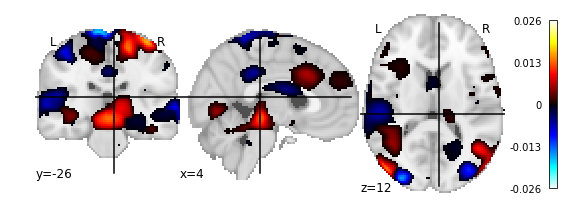

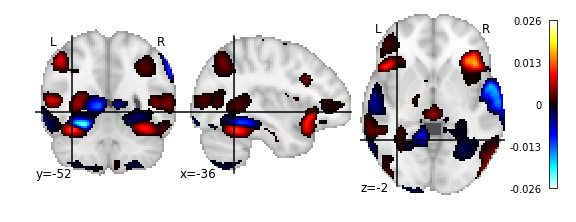

In [18]:
plot_stat_map(img0)
plot_stat_map(img1)

0.28064376


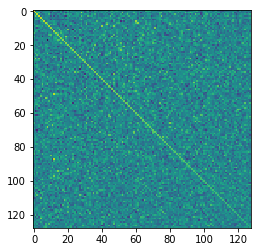

In [19]:
corr = snr1_.dot(snr0_.T)
plt.imshow(corr)
print(np.mean(np.diag(corr)))

In [42]:
from scipy.linalg import orthogonal_procrustes

In [74]:
R, scale = orthogonal_procrustes(snr0.T, ref.T)

In [75]:
R

array([[ 0.1715891 ,  0.27157423, -0.05469853, ..., -0.12562214,
         0.0027624 , -0.03662933],
       [ 0.05039806,  0.24057062,  0.11969645, ..., -0.20654306,
        -0.00493732,  0.06297854],
       [-0.05503231, -0.01313847,  0.04751709, ..., -0.11897652,
         0.0774088 , -0.0555988 ],
       ...,
       [-0.0634648 , -0.03780291,  0.04373235, ..., -0.00557773,
        -0.01297139,  0.02881206],
       [ 0.07284795, -0.00390806, -0.09131246, ...,  0.01043921,
        -0.04684579,  0.02405596],
       [-0.10669472,  0.10088592,  0.22312744, ..., -0.12363334,
        -0.09765214,  0.11728125]], dtype=float32)

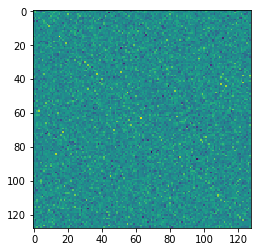

In [76]:
plt.imshow(R)

In [96]:
snr0_ = snr0 - snr0.mean(axis=0, keepdims=True)
ref_ = ref - ref.mean(axis=0, keepdims=True)

snr0_ /= np.sqrt(np.sum(snr0_ ** 2, axis=1, keepdims=True))
ref_ /= np.sqrt(np.sum(ref_ ** 2, axis=1, keepdims=True))

R, scale = orthogonal_procrustes(snr0_.T, ref_.T)

In [104]:
corr = snr0_.dot(ref_.T)

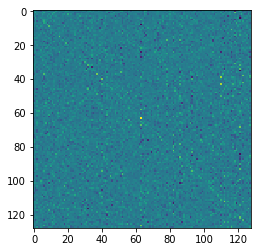

In [105]:
plt.imshow(corr)

In [52]:
R.dot(snr0)

array([[ 1.60655749e-04,  5.34775427e-05, -5.24609241e-05, ...,
        -6.54771226e-04, -6.79296092e-04, -6.67074870e-04],
       [ 2.98339757e-04,  2.45483476e-04,  1.63053963e-04, ...,
         1.19114033e-04,  1.19809207e-04,  1.19519449e-04],
       [-2.88542651e-04, -4.64814279e-04, -6.76441181e-04, ...,
        -1.01084690e-04, -1.17530624e-04, -1.09144785e-04],
       ...,
       [-4.67801437e-04, -4.99471673e-04, -5.12310187e-04, ...,
         5.72456222e-04,  5.87804243e-04,  5.80247608e-04],
       [ 9.25319691e-05,  1.11123627e-04,  9.87803141e-05, ...,
         1.00419929e-05,  2.67053183e-05,  1.81566666e-05],
       [ 3.95857642e-05,  1.51001459e-05, -1.37194329e-05, ...,
         3.82446015e-04,  3.96938151e-04,  3.89713910e-04]], dtype=float32)

In [106]:
img = masker.inverse_transform(snr0)

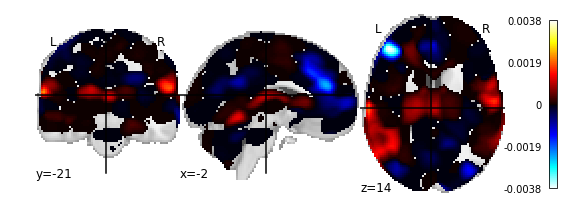

In [110]:
plot_stat_map(index_img(img, 100))

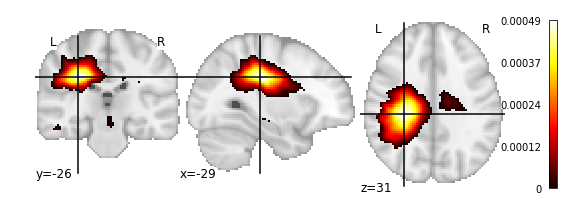

In [112]:
plot_stat_map(index_img(components_128, 100))